In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from sklearn import model_selection
from sklearn import preprocessing
from PIL import Image
from torchvision import transforms
import torch
from torch.utils.data import DataLoader, Dataset
import os
import matplotlib.pyplot as plt

In [2]:
def get_device():
  return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def bind_gpu(data):
  device = get_device()
  if isinstance(data, (list, tuple)):
    return [bind_gpu(data_elem) for data_elem in data]
  else:
    return data.to(device, non_blocking=True)

In [3]:
data = pd.read_csv('kaggle/input/artemis-full/artemis.csv')
data = data[:1000]

In [4]:
data.head()

,Unnamed: 0,art_style,painting,emotion,utterance,repetition,path
0,0,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,"She seems very happy in the picture, and you w...",10,/kaggle/input/wikiart/Post_Impressionism/vince...
1,1,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,sadness,This woman has really knotty hands which makes...,10,/kaggle/input/wikiart/Post_Impressionism/vince...
2,2,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,"When looking at this woman, I am filled with c...",10,/kaggle/input/wikiart/Post_Impressionism/vince...
3,3,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,contentment,"A woman looking at ease, peaceful, and satisfi...",10,/kaggle/input/wikiart/Post_Impressionism/vince...
4,4,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,awe,She looks like a lady from that past that migh...,10,/kaggle/input/wikiart/Post_Impressionism/vince...


In [5]:
data.shape

(1000, 7)

In [6]:
#sample_size = int(0.002 * len(data))  # Uzorkujemo 10% originalnog skupa
#data = data.sample(n=sample_size, random_state=42)
#print(f"Broj zapisa nakon uzorkovanja: {len(data)}")


In [7]:
#ne odgovara mi putanja
correct_path_prefix = 'kaggle/input/wikiart/'
def update_path(path):
    return path.replace('/kaggle/input/wikiart/', correct_path_prefix)

data['path'] = data['path'].apply(update_path)

In [8]:
# Uzimamo prvih par redova iz DataFrame-a
sample_paths = data['path'].head(10)
#Iteriramo kroz putanje i prikazujemo slike
#for path in sample_paths:
#    try:
#        img = mpimg.imread(path)
#        imgplot = plt.imshow(img)
#        plt.axis('off')  # Uklanja ose oko slike
#        plt.show()
#    except FileNotFoundError:
#        print(f"Slika nije pronađena na putanji: {path}")

In [9]:
#ISTRAZIVANJE PODATALA

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1000 non-null   int64 
 1   art_style   1000 non-null   object
 2   painting    1000 non-null   object
 3   emotion     1000 non-null   object
 4   utterance   1000 non-null   object
 5   repetition  1000 non-null   int64 
 6   path        1000 non-null   object
dtypes: int64(2), object(5)
memory usage: 54.8+ KB


In [11]:
#emocije su najzastupljenije.
data['emotion'].value_counts()

emotion
contentment       328
awe               218
sadness           117
amusement         109
fear               92
excitement         62
disgust            37
something else     31
anger               6
Name: count, dtype: int64

In [12]:
# Ovde zakljucujemo značajna neravnoteža u distribuciji emocija, gde su emocije poput Contentment i 
#Awe mnogo češće zastupljene nego emocije poput Disgust i Anger.

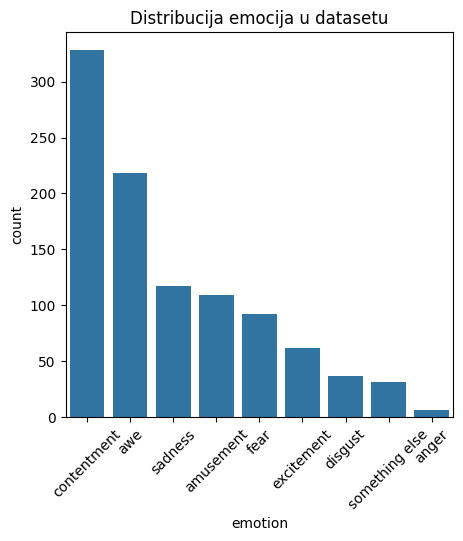

In [13]:
plt.figure(figsize=(5,5))
sns.countplot(x='emotion', data=data, order=data['emotion'].value_counts().index)
plt.title('Distribucija emocija u datasetu')
plt.xticks(rotation=45)
plt.show()

In [14]:
#Podela podataka 

In [15]:
image_paths = data['path'].values
emotions = data['emotion'].values
# Pretvaranje emocija u numeričke vrednosti
label_encoder = preprocessing.LabelEncoder()
emotions_encoded = label_encoder.fit_transform(emotions)


In [16]:
# Podela na train, validation, i test setove
image_paths_train, image_paths_temp, y_train, y_temp = model_selection.train_test_split(image_paths, emotions_encoded, test_size=0.2, random_state=7)
image_paths_val, image_paths_test, y_val, y_test = model_selection.train_test_split(image_paths_temp, y_temp, test_size=0.5, random_state=7)

# Definisanje transformacija za slike (promena veličine i normalizacija)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Promena veličine slika
    transforms.ToTensor(),  # Pretvaranje slike u tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizacija prema ImageNet standardu
])



In [17]:
import torch

class ArtDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Load image
        label = torch.zeros(len(label_encoder.classes_))
        label[self.labels[idx]] = 1  # Set the appropriate positions to 1
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [18]:
# Kreiranje DataLoader-a za svaki set
train_dataset = ArtDataset(image_paths_train, y_train, transform=transform)
val_dataset = ArtDataset(image_paths_val, y_val, transform=transform)
test_dataset = ArtDataset(image_paths_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [19]:
import torchvision.models as models
import torch.nn as nn

# Load the pre-trained ResNet18 model
resnet18 = models.resnet18(pretrained=True)

# Modify the final layer to match the number of possible emotions
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, len(label_encoder.classes_))

# Use Sigmoid activation for multi-label classification
model1 = nn.Sequential(
    resnet18,
    nn.Sigmoid()
)

model1 = model1.to(get_device())

/home/aleksandra/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aleksandra/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
import torch.optim as optim
import torch

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.00001)


In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Initialize lists to store losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 4
device = get_device()

for epoch in range(num_epochs):
    model1.train()
    running_loss = 0.0
    running_corrects = 0
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = bind_gpu((images, labels))
        
        optimizer.zero_grad()
        outputs = model1(images)
        
        loss = criterion(outputs, labels.float())  # Convert labels to float for BCEWithLogitsLoss
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # Convert outputs to binary predictions (threshold = 0.5)
        preds = (outputs > 0.5).float()
        running_corrects += (preds == labels).float().mean().item()
        
        # Print progress for every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f"  Batch [{batch_idx+1}/{len(train_loader)}] - Loss: {loss.item():.4f}")

    # Calculate average training loss and accuracy
    avg_train_loss = running_loss / len(train_loader)
    avg_train_acc = running_corrects / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    model1.eval()
    val_loss = 0.0
    val_corrects = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            images, labels = bind_gpu((images, labels))
            
            outputs = model1(images)
            loss = criterion(outputs, labels.float())
            
            val_loss += loss.item()

            preds = (outputs > 0.5).float()
            val_corrects += (preds == labels).float().mean().item()
            
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_corrects / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] completed.")
    print(f"  Average Training Loss: {avg_train_loss:.4f} | Training Accuracy: {avg_train_acc:.4f}")
    print(f"  Average Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {avg_val_acc:.4f}")

# Convert all_labels and all_preds to numpy arrays for the confusion matrix
all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)



Epoch [1/4]
  Batch [10/25] - Loss: 0.9139
  Batch [20/25] - Loss: 0.9101
Epoch [1/4] completed.
  Average Training Loss: 0.9142 | Training Accuracy: 0.5463
  Average Validation Loss: 0.9090 | Validation Accuracy: 0.5686

Epoch [2/4]
  Batch [10/25] - Loss: 0.8936
  Batch [20/25] - Loss: 0.8884
Epoch [2/4] completed.
  Average Training Loss: 0.8967 | Training Accuracy: 0.6146
  Average Validation Loss: 0.8961 | Validation Accuracy: 0.6085

Epoch [3/4]
  Batch [10/25] - Loss: 0.8828
  Batch [20/25] - Loss: 0.8695
Epoch [3/4] completed.
  Average Training Loss: 0.8808 | Training Accuracy: 0.6764
  Average Validation Loss: 0.8824 | Validation Accuracy: 0.6632

Epoch [4/4]
  Batch [10/25] - Loss: 0.8700
  Batch [20/25] - Loss: 0.8596
Epoch [4/4] completed.
  Average Training Loss: 0.8653 | Training Accuracy: 0.7249
  Average Validation Loss: 0.8702 | Validation Accuracy: 0.6910


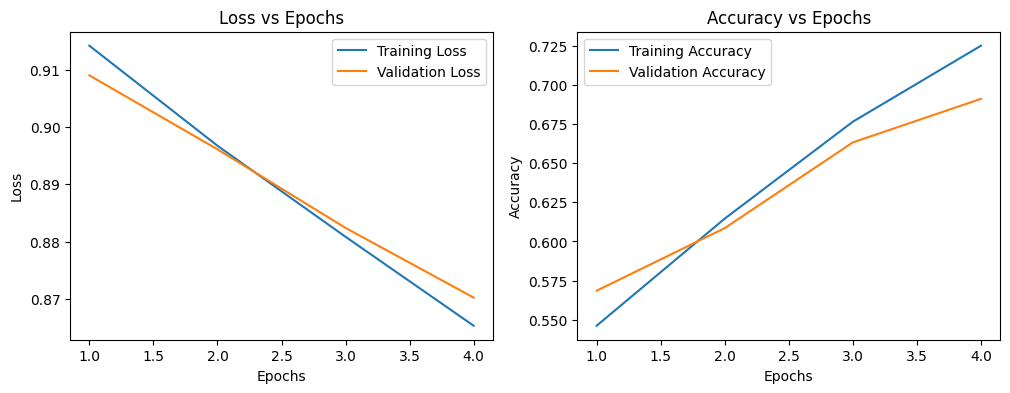

In [22]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.show()


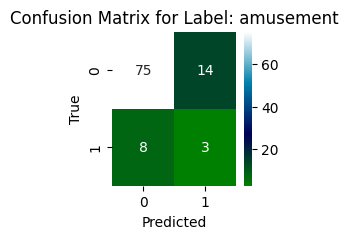

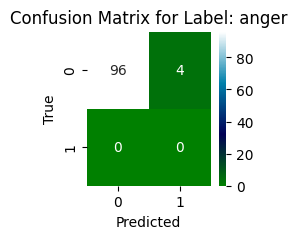

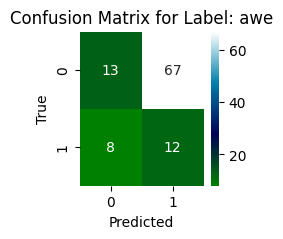

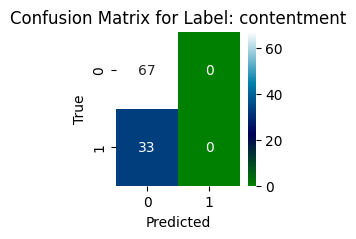

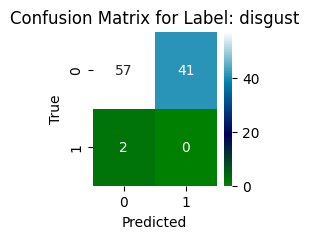

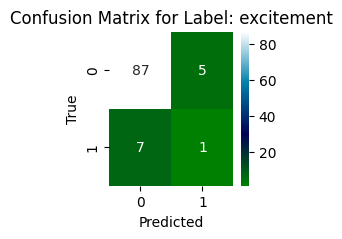

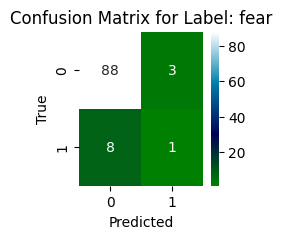

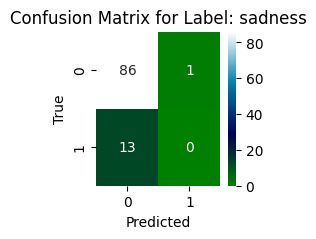

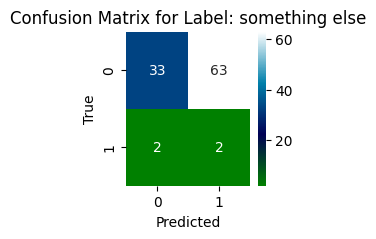

In [23]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

# Calculate the confusion matrix for each label
conf_matrix = multilabel_confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix for each label
for i, matrix in enumerate(conf_matrix):
    plt.figure(figsize=(2, 2))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='ocean')
    plt.title(f'Confusion Matrix for Label: {label_encoder.classes_[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [24]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model1(inputs)
    print(outputs)
    break  # Check the output for one batch and exit

predicted = (outputs > 0.3).float()
for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model1(inputs)
    
    print("Model Outputs: ", outputs)
    print("Predicted Labels (before threshold): ", outputs)
    
    predicted = (outputs > 0.5).float()
    print("Predicted Labels (after threshold): ", predicted)
    
    print("True Labels: ", labels)
    break  # Check for one batch

tensor([[0.4163, 0.3921, 0.5953, 0.1283, 0.3812, 0.3461, 0.2289, 0.3536, 0.6981],
        [0.2852, 0.2950, 0.7915, 0.1428, 0.5194, 0.5564, 0.3359, 0.4949, 0.4916],
        [0.1863, 0.2580, 0.8323, 0.2226, 0.3720, 0.5300, 0.2832, 0.2040, 0.5596],
        [0.6438, 0.3205, 0.7066, 0.1407, 0.6161, 0.4666, 0.3264, 0.3121, 0.7189],
        [0.1905, 0.2379, 0.6020, 0.2259, 0.3801, 0.2607, 0.4423, 0.3463, 0.3674],
        [0.2796, 0.4228, 0.5464, 0.3446, 0.4657, 0.3026, 0.3062, 0.2419, 0.5289],
        [0.5265, 0.2533, 0.8069, 0.2426, 0.2783, 0.1490, 0.2508, 0.2491, 0.6633],
        [0.5258, 0.3909, 0.6192, 0.2269, 0.4288, 0.2786, 0.2960, 0.3053, 0.7489],
        [0.3837, 0.3560, 0.3617, 0.1732, 0.2665, 0.3461, 0.3988, 0.3283, 0.5044],
        [0.3239, 0.3821, 0.8114, 0.2627, 0.4197, 0.2081, 0.3693, 0.2759, 0.4872],
        [0.5419, 0.2190, 0.2494, 0.1915, 0.5299, 0.4339, 0.3493, 0.3090, 0.7524],
        [0.5277, 0.3939, 0.7649, 0.1778, 0.6343, 0.3482, 0.4328, 0.2940, 0.5682],
        [0.4974,

In [25]:
# Izgradnja osnovnog CNN modela u PyTorch-u

In [26]:
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_multilabel_classification_per_class(model, criterion, loader):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    predicted_labels, true_labels = [], []
    device = get_device()

    with torch.no_grad():  # No gradient computation during evaluation
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())  # Compute the loss

            total_loss += loss.item()

            # Apply sigmoid and threshold for multi-label classification
            predicted = (outputs > 0.5).float()

            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            total_samples += labels.size(0)

    # Convert to numpy arrays for metric calculation
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
    print(f'Model evaluation:')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

    # Plot confusion matrices for each label
    num_classes = true_labels.shape[1]
    for i in range(num_classes):
        cm = confusion_matrix(true_labels[:, i], predicted_labels[:, i])
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for Class {i} - {label_encoder.classes_[i]}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    avg_loss = total_loss / len(loader)
    return avg_loss, accuracy

# Example usage:
# test_loss, test_accuracy = evaluate_multilabel_classification_per_class(model1, criterion, test_loader)


Model evaluation:
Accuracy: 0.0400
Precision: 0.0876
Recall: 0.2400
F1 Score: 0.1192


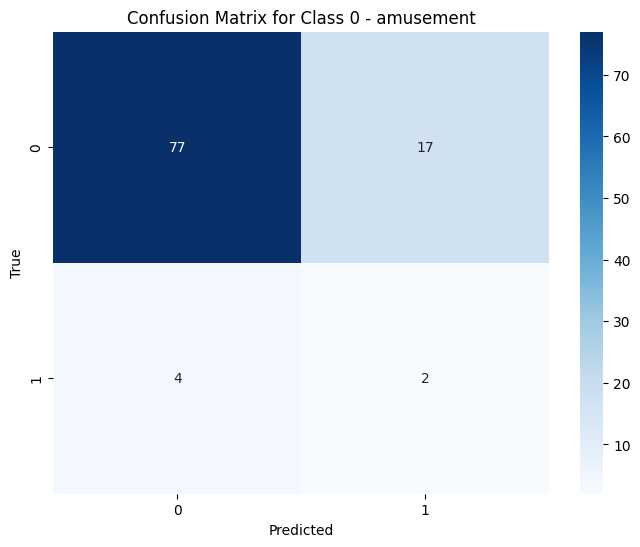

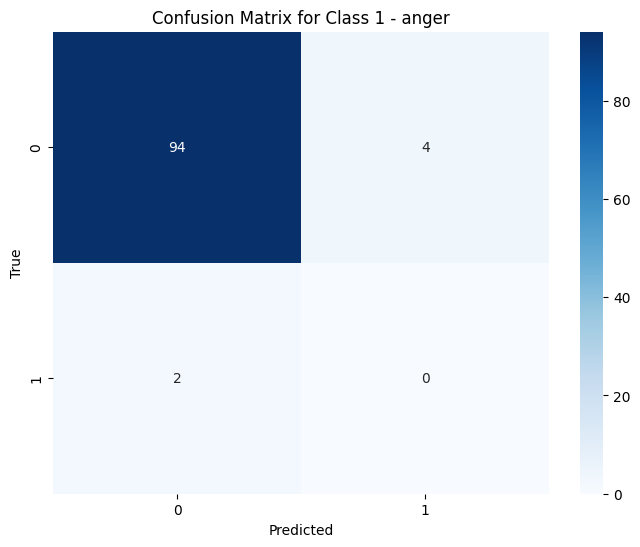

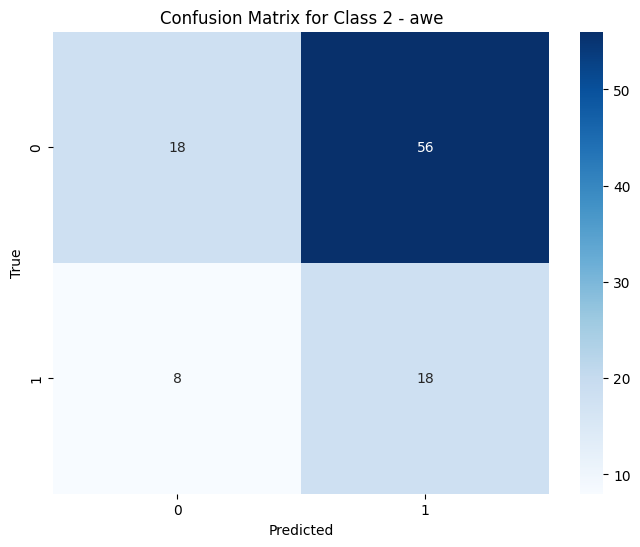

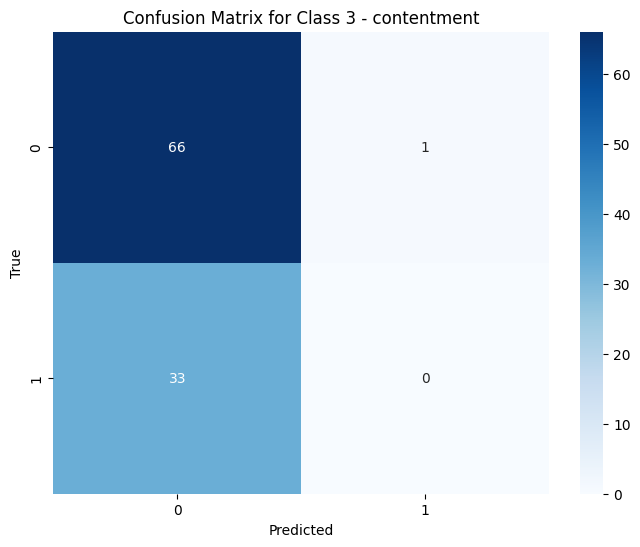

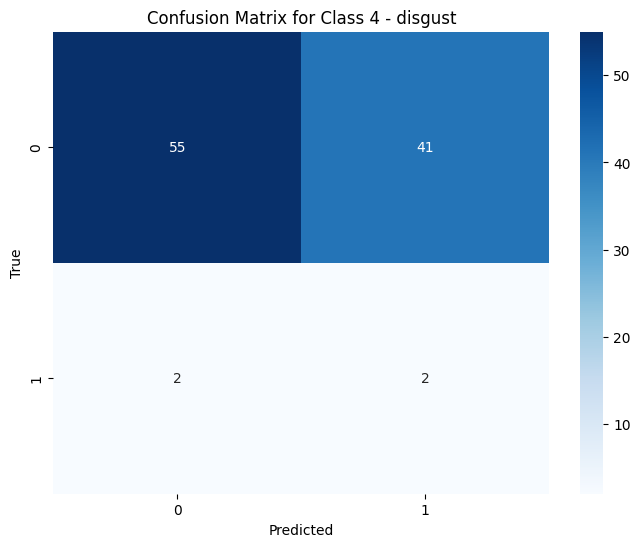

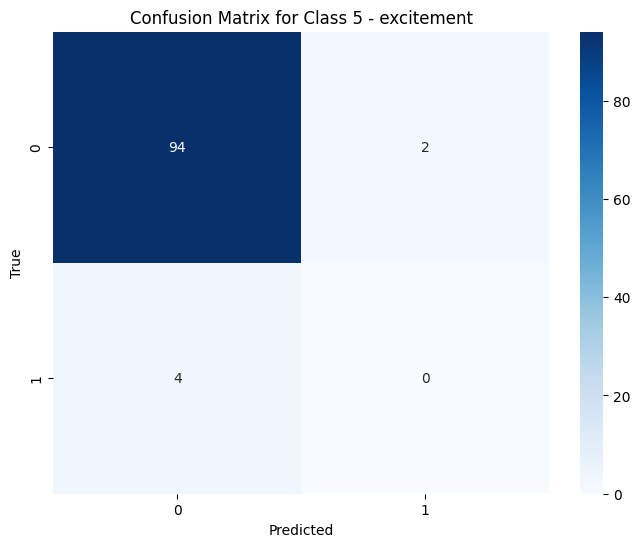

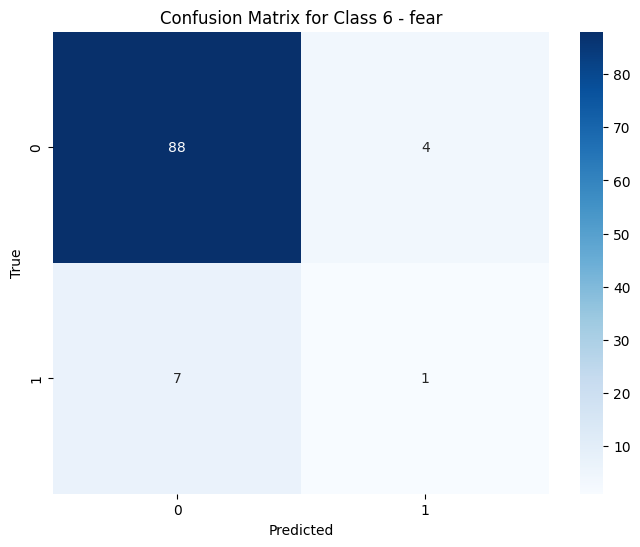

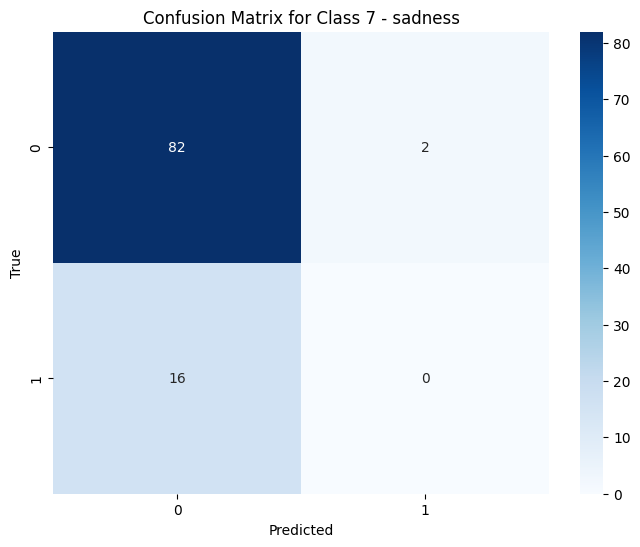

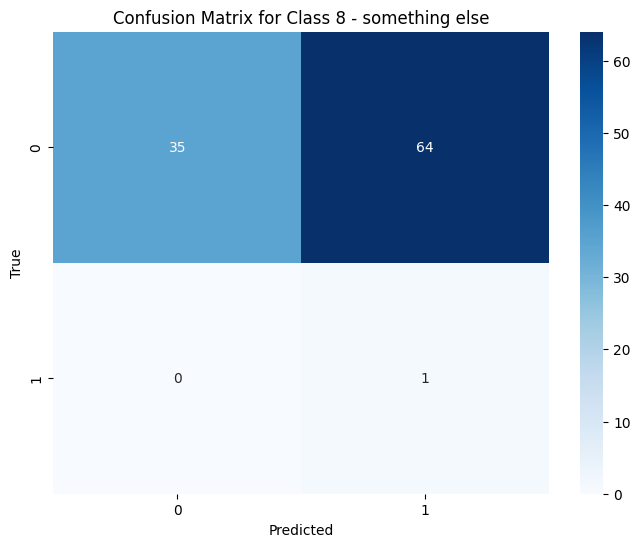

In [27]:
test_loss, test_accuracy = evaluate_multilabel_classification_per_class(model1, criterion, test_loader)


NameError: name 'evaluate_multilabel_classification' is not defined

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Inicijalizacija modela
num_classes = len(label_encoder.classes_)  # Broj klasa je jednak broju jedinstvenih emocija
model = SimpleCNN(num_classes)

In [ ]:
import torch.optim as optim

# Definisanje kriterijuma i optimizatora
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Prebacivanje modela na GPU
device = get_device()
model = SimpleCNN(num_classes).to(device)

# Ažurirano treniranje modela sa GPU podrškom
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = bind_gpu((images, labels))  # Prebacivanje podataka na GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

    # Validacija modela
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = bind_gpu((images, labels))  # Prebacivanje podataka na GPU
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss/len(val_loader)}, Accuracy: {val_accuracy:.2f}%')

# Evaluacija modela na test skupu
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = bind_gpu((images, labels))  # Prebacivanje podataka na GPU
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss/len(test_loader)}, Accuracy: {test_accuracy:.2f}%')